In [15]:
from fenics import * 
import matplotlib.pyplot as plt
import numpy as np
import time

#suppress some output
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [16]:
## Simulation and mesh parameters

# mesh size
Lx = 1.0         
Ly = 20.0

# set grid size
mx = 20/2
my = int(mx*Ly)

# delta slice
J = 11
DELTA = np.linspace(0.0,1.0,J);

# number of eigenvalues
evals = 2*1*int(Lx*Ly)
E = np.zeros((J,evals))

In [17]:
## Mesh

# set up honeycomb lattice
q = 4*np.pi/(sqrt(3))
k1 = q*np.array([1,sqrt(3)])/2.0
k2 = q*np.array([1,-sqrt(3)])/2.0
k3 = -(k1+k2)
K = (k1-k2)/3

v1_h = np.array([sqrt(3),1])/2.0
v2_h = np.array([sqrt(3),-1])/2.0

# different edges
# a1 = 1; b1 = 1; a2 = 0; b2 = 1;     # armchair
a1, b1, a2, b2 = 1, 0, 0, 1       # zigzag
# a1 = 3; b1 = 2; a2 = 1; b2 = 1;     # general
# a1 = 2; b1 = 1; a2 = 1; b2 = 1;     # general

v1 = a1*v1_h + b1*v2_h
v2 = a2*v1_h + b2*v2_h

ktilde = -b1*k1+a1*k2         # general

# create mesh      
def honeycomb_cylinder(x, y):
    return [v1[0]*x + v2[0]*y, v1[1]*x + v2[1]*y]

mesh = RectangleMesh(Point(-Lx/2,-Ly/2),Point(Lx/2,Ly/2),mx,my)#, 'left') # “left”, “right”, “left/right”, “crossed”
x = mesh.coordinates()[:,0]
y = mesh.coordinates()[:,1]

x_hat, y_hat = honeycomb_cylinder(x, y)
xy_hat_coor = np.array([x_hat, y_hat]).transpose()
mesh.coordinates()[:] = xy_hat_coor
#plot(mesh), interactive()

In [18]:
## Boundary Conditions

# sub domain for Dirichlet boundary condition
class DirichletBoundary(SubDomain):
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv
        return bool( ( near(y_r, -Ly/2.0) or near(y_r, Ly/2.0) ) and on_boundary)
    
# sub domain for Periodic boundary condition
class PeriodicBoundary(SubDomain):

    # left boundary is "target domain" G
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        return bool( ( near(x_r, -Lx/2.0) and near(x_r, -Lx/2.0) ) and on_boundary)

    # map right boundary (H) to left boundary (G)
    def map(self, x, y):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        x_h = x_r - (Lx - 0)
        y_h = y_r
        
        y[0] = v1[0]*x_h + v2[0]*y_h
        y[1] = v1[1]*x_h + v2[1]*y_h
        
## perfectly periodic problem

# sub domain for Periodic boundary condition
class PerfectlyPeriodicBoundary(SubDomain):

    # left boundary is "target domain" G
    def inside(self, x, on_boundary):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        return bool( (near(x_r, -Lx/2.0) or near(y_r, -Ly/2.0)) and 
                    (not ((near(x_r, -Lx/2.0) and near(y_r, +Ly/2.0)) or 
                            (near(x_r, +Lx/2.0) and near(y_r, -Ly/2.0))) ) and on_boundary)
        
    # map right boundary (H) to left boundary (G)
    def map(self, x, y):
        detv = v1[0]*v2[1] - v2[0]*v1[1]
        x_r = (v2[1]*x[0] - v2[0]*x[1])/detv
        y_r = (-v1[1]*x[0] + v1[0]*x[1])/detv 
        
        if near(x_r, +Lx/2.0) and near(y_r, +Ly/2.0):
            x_h = x_r  - Lx - 0.0
            y_h = y_r - Ly - 0.0
        elif near(x_r, +Lx/2.0):
            x_h = x_r  - Lx - 0.0
            y_h = y_r
        else:   # near(y_r, +Ly/2.0)
            x_h = x_r 
            y_h = y_r - Ly - 0.0
            
        y[0] = v1[0]*x_h + v2[0]*y_h
        y[1] = v1[1]*x_h + v2[1]*y_h

In [19]:
## Finite Elements

periodic = PeriodicBoundary()
#periodic = PerfectlyPeriodicBoundary()

#V = FunctionSpace(mesh, "CG", 2, constrained_domain=periodic)

P2 = FiniteElement("P", triangle, 2)
element = MixedElement([P2, P2])
W = FunctionSpace(mesh, element, constrained_domain=periodic)

# create Dirichlet boundary condition
dbc = DirichletBoundary()
bcs = [DirichletBC(W.sub(0), Constant(0.0), dbc), DirichletBC(W.sub(1), Constant(0.0), dbc)]

# define functions
(u_r, u_i) = TrialFunctions(W)
(v_r, v_i) = TestFunctions(W)

In [20]:
## Potential terms
V_e = Expression('4.0-1.0*(cos(k10*x[0]+k11*x[1]) + cos(k20*x[0]+k21*x[1]) + cos(k30*x[0]+k31*x[1]))', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)
W_o = Expression('sin(k10*x[0]+k11*x[1]) + sin(k20*x[0]+k21*x[1]) + sin(k30*x[0]+k31*x[1])', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)
V_e_2 = Expression('cos(k10*x[0]+k11*x[1]) + cos(k20*x[0]+k21*x[1]) + cos(k30*x[0]+k31*x[1])', \
                 k10=k1[0], k11=k1[1], k20=k2[0], k21=k2[1], k30=k3[0], k31=k3[1], degree=1)

# quasimomentum
k = Constant(K)
#k = Constant((0,0))
#k = Constant(K+(1/2.0-1/3.0)*k1)

In [21]:
## Computations

# assemble mass matrix
m_r = (u_r*v_r + u_i*v_i)*dx
m_i = (-u_r*v_i + u_i*v_r)*dx
M = PETScMatrix()
assemble(m_r+m_i, tensor=M)

#L = inner(Constant(1.0), v_r+v_i)*dx
#b = PETScVector()
#assemble_system(m_r+m_i, L, A_tensor=M, b_tensor=b)

# eigenvalue solver
def compute_evals(A, E, M, r):
    
    # create eigensolver
    eigensolver = SLEPcEigenSolver(A,M)
    eigensolver.parameters['spectrum'] = 'smallest real'
    eigensolver.parameters['solver']   = 'krylov-schur'
    eigensolver.parameters['tolerance'] = 1.e-10   # 1.e-12
    #eigensolver.parameters['maximum_iterations'] = 1000
    #eigensolver.parameters['problem_type'] = 'gen_hermitian'


    # solve for eigenvalues
    eigensolver.solve(evals)
    
    for i in range(0,evals):
        if i <= (eigensolver.get_number_converged()-1):
            E[r][i] = eigensolver.get_eigenvalue(i)[0]
    
    #return np.sort(E)
    return E

program_starts = time.time()

r = 0

# main computation
for delta in DELTA:

    # define problem
    kappa = Expression('tanh(delta*(k0*x[0]+k1*x[1]))', delta = delta, k0=ktilde[0], k1=ktilde[1], degree=1)
    # kappa = 1.0
    
    #spatial inversion symmetry breaking
    #U_delta = V_e + delta*kappa*W_o
    #C = as_matrix( ((U_delta, 0.0), (0.0, U_delta)) )
    #a_r = ( inner(C*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) )*dx
    #a_i = ( inner(C*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) - inner(C*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) )*dx    
    
    #time reversal symmetry breaking
    C_r = as_matrix( ((V_e, 0.0), (0.0, V_e)) )
    C_i = as_matrix( ((0.0, -delta*kappa*V_e_2), (delta*kappa*V_e_2, 0.0)) )
    a_r = ( inner(C_r*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C_r*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) +\
           -inner(C_i*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) + inner(C_i*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) )*dx
    a_i = ( inner(C_r*(grad(u_i)+k*u_r), grad(v_r)-k*v_i) - inner(C_r*(grad(u_r)-k*u_i), grad(v_i)+k*v_r) +\
           +inner(C_i*(grad(u_r)-k*u_i), grad(v_r)-k*v_i) + inner(C_i*(grad(u_i)+k*u_r), grad(v_i)+k*v_r) )*dx

    # assemble stiffness matrix
    A = PETScMatrix()
    
    assemble(a_r+a_i, tensor=A)
    [bc.apply(A) for bc in bcs]
    
    # assemble_system(a_r+a_i, L, bcs, A_tensor=A, b_tensor=b)
    
    E = compute_evals(A, E, M, r)
    
    r += 1
    print r/float(J)
    
print time.time() - program_starts

0.0909090909091
0.181818181818
0.272727272727
0.363636363636
0.454545454545
0.545454545455
0.636363636364
0.727272727273
0.818181818182
0.909090909091
1.0
969.975364923


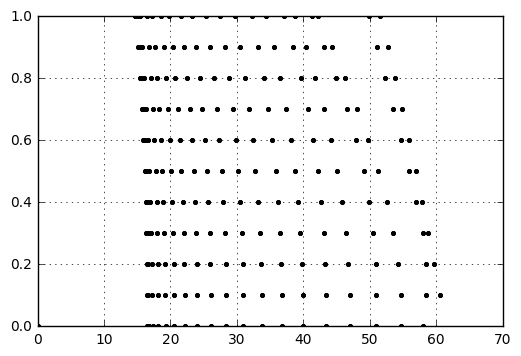

In [22]:
## Plotting eigenvalues

plt.plot(E,DELTA,'k.')
# plt.plot(E[:,int(2*Ly+2)],DELTA,'r.')
# plt.title('E(delta) Ly20pt5 mx20 kpar0pt5')
plt.grid(True)
plt.show()

In [23]:
break

SyntaxError: 'break' outside loop (<ipython-input-23-b20fcc2397e7>, line 1)

In [ ]:
## Plotting eigenfunctions
    
eigensolver = SLEPcEigenSolver(A,M)
eigensolver.parameters['spectrum'] = 'smallest real'
eigensolver.parameters['solver']   = 'krylov-schur'
eigensolver.parameters['tolerance'] = 1.e-10   # 1.e-12
eigensolver.solve(evals)

In [ ]:
r, c, rx, cx = eigensolver.get_eigenpair(int(2*Ly+0))

u = Function(W)
u.vector()[:] = rx
u_r, u_i = split(u)
plot(u_r)
interactive()

In [ ]:
#r, c, rx, cx = eigensolver.get_eigenpair(int(2*Ly-2))
#
#u = Function(W)
#u.vector()[:] = rx
#u_r, u_i = split(u)
#plot(u_r)
#interactive()

In [ ]:
#r, c, rx, cx = eigensolver.get_eigenpair(int(2*Ly+2))
#
#u = Function(W)
#u.vector()[:] = rx
#u_r, u_i = split(u)
#plot(u_r)
#interactive()

In [ ]:
#import scipy.io
#
#vals = np.empty(((mx + 1) * (my + 1), 2), dtype=np.float_)
#for v in vertices(mesh):
#    vals[v.index()] = u(*mesh.coordinates()[v.index()])

# scipy.io.savemat('matlab export/Psi_x_test.mat', dict(Psi=vals, x=mesh.coordinates(), mx=mx, my=my))

# scipy.sparse.csr_matrix(M.array())